In [85]:
import numpy as np
import matplotlib.pyplot as plt
import blip_analysis as ba
import exp_blip_models as ebm
import numpy as np
import daskify
from scipy.stats import ttest_ind
import pickle
from matplotlib.gridspec import GridSpec
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tqdm import trange, tqdm
import dask
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
import copy
from scipy.stats import norm
import time
from sklearn.cluster import OPTICS
import importlib
importlib.reload(ebm)

b


<module 'exp_blip_models' from '/home/camp/warnert/working/Recordings/binary_pulses/blip_analysis/exp_blip_models.py'>

In [2]:
def plot_mean_and_std(ax, data, axis=-1, xs=None):
    mean_data = data.mean(axis=axis)
    std_data = data.std(axis=axis)
    if xs is None:
        xs = np.arange(len(mean_data))
    ax.plot(xs, mean_data)
    ax.fill_between(xs, mean_data-std_data, mean_data+std_data, alpha=0.5)
def set_global_ylims(axs, ylim=None):
    if ylim is None:
        ylims = [ax.get_ylim() for ax in axs]
        ylim = (np.min([y[0] for y in ylims]), np.max([y[1] for y in ylims]))
    for ax in axs:
        ax.set_ylim(ylim)

def split_and_classify(usrt_scattered, trial_indexes, scaled=True, shuffle=False, unit_count=130, pcad=True, pca_count=1, classifier=LinearSVC, classifier_params={}):
    unit_indexes = np.random.choice(range(130), replace=False, size=unit_count)
    train, test = ba.split_bs_data(usrt_scattered[unit_indexes])
    train_sum = train.sum(axis=-1)[:, trial_indexes].reshape(unit_count, -1).T
    test_sum = test.sum(axis=-1)[:, trial_indexes].reshape(unit_count, -1).T
    y_train = np.hstack([[i for j in range(60)] for i in trial_indexes])
    y_test = trial_indexes
    
    if scaled:
        scaler = StandardScaler()
        train_sum = scaler.fit_transform(train_sum)
        test_sum = scaler.transform(test_sum)
    svm = classifier(**classifier_params)
    if shuffle:
        np.random.shuffle(y_train)
    svm.fit(train_sum, y_train)
    return svm.score(test_sum, y_test), svm.predict(test_sum)

def dask_svm(X, y, test_size):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y)
    svm = RandomForestClassifier()
    svm.fit(X_train, y_train)
    pred = svm.predict(X_test)
    return pred, y_test

def generate_noisy_data(models, noise_level=10,repeats=60, method='add', unit_var_scale=1):
    all_pred_firings = []
    trial_array1 = np.append(models[0].trial_array, np.ones((32, 1)), axis=1)
    for model in models:
        pred_firings= []
        if len(model.pred_resp) != 32:
            model.fit()
        for i in range(repeats):
            if method == 'add':
                pred_firing  = model.pred_resp + norm.rvs(0, noise_level, size=32)
            elif method == 'unit_var':
                pred_firing = model.pred_resp + np.array([norm.rvs(0, j, size=1)[0]*unit_var_scale for j in model.unit_sr_var])
            pred_firings.append(pred_firing)
        all_pred_firings.append(pred_firings)
    all_pred_firings = np.array(all_pred_firings)
#    ys = [i for j in range(60) for i in range(32)]
    return all_pred_firings

def generate_and_dask(models, noise_level=10, repeats=100, method='unit_var', unit_var_scale=1, wait=True):
    X = generate_noisy_data(models, noise_level=noise_level, method=method, unit_var_scale=unit_var_scale).reshape(len(models), -1).T
    X_scattered = dasked.client.scatter(X)
    
    delayeds = [dask.delayed(dask_svm)(X_scattered, y_scatter, 32) for i in range(repeats)]
    dask_outs = dasked.client.compute(delayeds)
    dasked.current_futures = dask_outs
    


In [13]:
diff_models1 = pickle.Unpickler(open('../Fig4/230320_diff_models1.pkl', 'rb')).load()
diff_models2 = pickle.Unpickler(open('../Fig4/230320_diff_models2.pkl', 'rb')).load()
diff_models3 = pickle.Unpickler(open('../Fig4/230320_diff_models3.pkl', 'rb')).load()
onset_models1 = pickle.Unpickler(open('../Fig4/230320_onset_models1.pkl', 'rb')).load()
conc_models1 = pickle.Unpickler(open('../Fig4/230320_conc_models1.pkl', 'rb')).load()

unit_usrt1, unit_usrt2, unit_usrt3 = ba.load_usrts()
good_indexes = ba.get_stable_resp_indexes()

Found odour 1
Found odour 3
Found odour 5


In [4]:
model = diff_models1[0]
bin_weights1 = np.array([[j.x[:-1] for j in i.training_opts] for i in diff_models1])
bin_weights2 = np.array([[j.x[:-1] for j in i.training_opts] for i in diff_models2])
bin_weights3 = np.array([[j.x[:-1] for j in i.training_opts] for i in diff_models3])


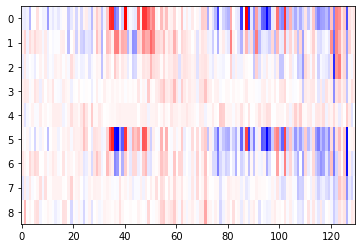

In [5]:
plt.imshow(bin_weights1.mean(axis=1).T, aspect='auto', cmap='bwr')
glyphs = ba.get_glyphs()

In [7]:
opts = OPTICS()

In [8]:
opts.fit(bin_weights1.mean(axis=1))

OPTICS()

In [9]:
counts = []
for i in np.unique(opts.labels_):
    print(len(np.where(opts.labels_ == i)[0]))
    counts.append(len(np.where(opts.labels_ == i)[0]))

72
44
7
7


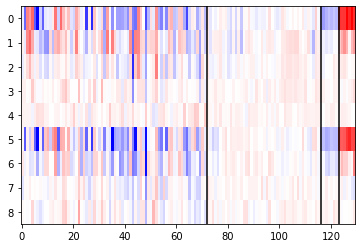

In [10]:
sorted_args = np.argsort(opts.labels_)
plt.imshow(bin_weights1.mean(axis=1).T[:, sorted_args], aspect='auto', cmap='bwr')
for i in np.cumsum(counts)[:-1]:
    plt.axvline(i, color='k')

In [11]:
cluster_bins = [bin_weights1.mean(axis=1).T[:, np.where(i == opts.labels_)[0]] for i in np.unique(opts.labels_)]

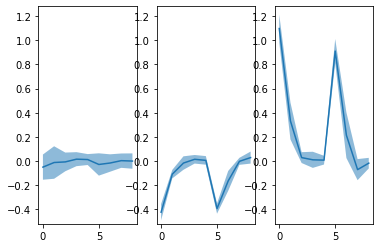

In [12]:
fig, ax = plt.subplots(1, 3)
plot_mean_and_std(ax[0], cluster_bins[1])
plot_mean_and_std(ax[1], cluster_bins[2])
plot_mean_and_std(ax[2], cluster_bins[3])
set_global_ylims(ax)

In [13]:
print(np.corrcoef(cluster_bins[1].mean(axis=1), cluster_bins[2].mean(axis=1)))

[[1.         0.92436564]
 [0.92436564 1.        ]]


360
6
24


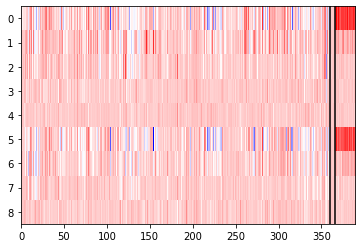

In [14]:
joined_weights = np.concatenate([bin_weights1, bin_weights2, bin_weights3])
joined_opts = OPTICS()
joined_opts.fit(joined_weights.mean(axis=1))

joined_counts = []
for i in np.unique(joined_opts.labels_):
    print(len(np.where(joined_opts.labels_ == i)[0]))
    joined_counts.append(len(np.where(joined_opts.labels_ == i)[0]))

joined_sorted_args = np.argsort(joined_opts.labels_)
plt.imshow(joined_weights.mean(axis=1).T[:, joined_sorted_args], aspect='auto', cmap='bwr')
for i in np.cumsum(joined_counts)[:-1]:
    plt.axvline(i, color='k')

# joined_cluster_bins = [joined_weights.mean(axis=1).T[:, np.where(i == joined_opts.labels_)[0]] for i in np.unique(joined_opts.labels_)]
# fig, ax = plt.subplots(1, 3)
# plot_mean_and_std(ax[0], joined_cluster_bins[1])
# plot_mean_and_std(ax[1], joined_cluster_bins[2])
# plot_mean_and_std(ax[2], joined_cluster_bins[3])

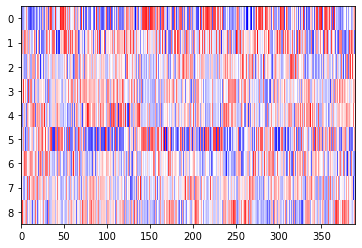

In [15]:
scaler =  StandardScaler()
joined_weights_scaled = scaler.fit_transform(joined_weights.mean(axis=1).T)
pca_scaled = PCA(n_components=9)
joined_pcad = pca_scaled.fit_transform(joined_weights_scaled.T)
plt.imshow(joined_weights_scaled, aspect='auto', cmap='bwr')
pca = PCA(n_components=9)
pcad_norm = pca.fit_transform(joined_weights.mean(axis=1))

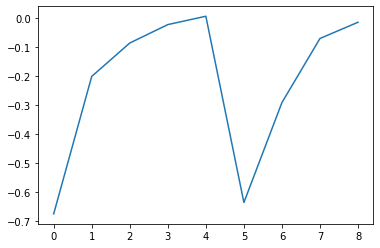

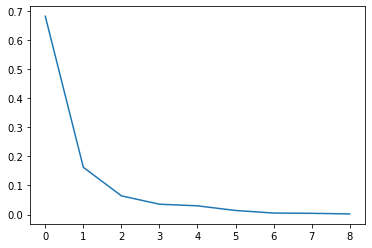

In [16]:
plt.plot(pca.components_[0])
plt.figure()
plt.plot(pca.explained_variance_ratio_)

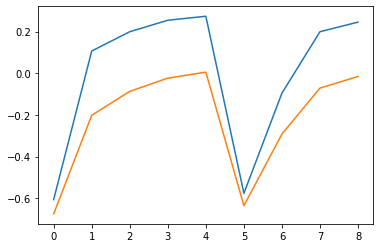

In [17]:
plt.plot(pca_scaled.components_[0]*-1)
plt.plot(pca.components_[0])

In [18]:
print(np.corrcoef(pca_scaled.components_[3], pca.components_[3]))

[[ 1.         -0.35019726]
 [-0.35019726  1.        ]]


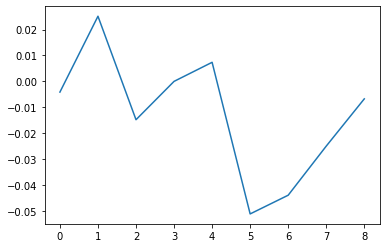

In [19]:
plt.plot(pca.mean_)

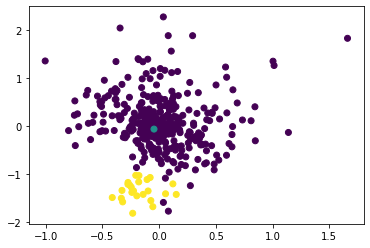

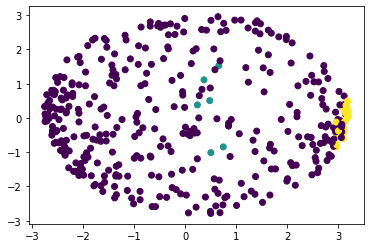

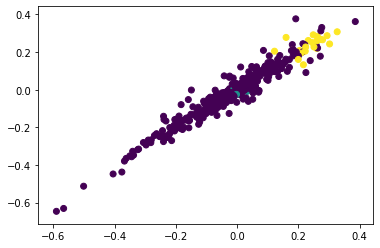

In [20]:
plt.scatter(pcad_norm[:, 1], pcad_norm[:,0], c=joined_opts.labels_)
plt.figure()
plt.scatter(joined_pcad[:, 0], joined_pcad[:, 1], c=joined_opts.labels_)
plt.figure()
plt.scatter(joined_weights.mean(axis=-1)[:, 0], joined_weights.mean(axis=-1)[:, 1], c=joined_opts.labels_)

In [21]:
pca1 = PCA(n_components=9)
print(bin_weights1.shape)
pcad_bw1 = pca1.fit_transform(bin_weights1.mean(axis=1)) 

(130, 100, 9)


In [22]:
def return_models(bin_weights, base_models, saved_components=1):
    pca = PCA(n_components=9)
    pcad_bw = pca.fit_transform(bin_weights.mean(axis=1))
    pcad_bw[:, saved_components:] = 0
    returned_weights = pca.inverse_transform(pcad_bw)
    returned_models = [copy.deepcopy(i) for i in base_models]
    [i.fit() for i in returned_models]
    threshes = [i.opt_out.x[-1] for i in returned_models]
    joined_weights = [list(returned_weights[i]) + [threshes[i]] for i in range(len(returned_weights))]
    [j.fit(W=joined_weights[i]) for i, j in enumerate(returned_models)]
    return returned_models

returned_models1 = return_models(bin_weights1, diff_models1)
returned_models2 = return_models(bin_weights2, diff_models2)
returned_models3 = return_models(bin_weights3, diff_models3)
all_returned_models1 = [return_models(bin_weights1, diff_models1, i) for i in range(9)]
all_returned_models2 = [return_models(bin_weights2, diff_models2, i) for i in range(9)]
all_returned_models3 = [return_models(bin_weights3, diff_models3, i) for i in range(9)]


KeyboardInterrupt: 

NameError: name 'returned_models' is not defined

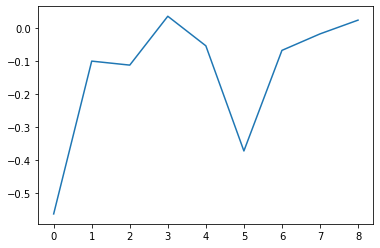

In [22]:

plt.plot(returned_models1[10].opt_out.x[:-1])
plt.plot(returned_models[10].opt_out.x[:-1])

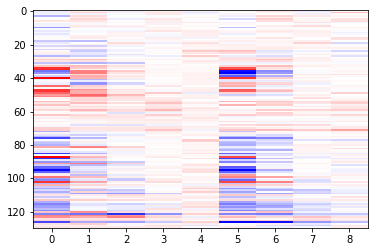

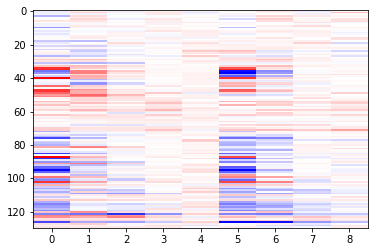

In [ ]:
plt.imshow([i.opt_out.x[:-1] for i in returned_models1], aspect='auto', cmap='bwr')
plt.figure()
plt.imshow([i.opt_out.x[:-1] for i in returned_models], aspect='auto', cmap='bwr')

In [ ]:
pcad_bw1[:, 1:] = 0

In [ ]:
returned_weights1 = pca1.inverse_transform(pcad_bw1)

In [ ]:
returned_models = [copy.deepcopy(i) for i in diff_models1]
[i.fit() for i in returned_models]
threshes = [i.opt_out.x[-1] for i in returned_models]
joined_weights = [list(returned_weights1[i]) + [threshes[i]] for i in range(len(returned_weights1))]
[j.fit(W=joined_weights[i]) for i, j in enumerate(returned_models)];

In [130]:
dasked = daskify.Daskified()
dasked.start_cluster()

In [132]:
ys = [i for j in range(60) for i in range(32)]
y_scatter = dasked.client.scatter(ys)

In [26]:
all_futures = []
for model_type in [all_returned_models1, all_returned_models2, all_returned_models3]:
    for model in tqdm(model_type, position=0, leave=False):
        for i in range(20):
            generate_and_dask(model, method='add', noise_level=i)
            all_futures.append(dasked.current_futures)
all_futures = np.concatenate(all_futures)
dasked.current_futures = all_futures
dasked.current_futures = list(dasked.current_futures)

In [7]:
generate_and_dask(diff_models1)

In [28]:
dasked.check_progress()

finished 100


In [93]:
print(len(dasked.current_futures))

6000


In [29]:
res = dasked.collect_results()

In [31]:
print(np.array(res).shape)

(100, 2, 32)


In [118]:
res = np.array(res).reshape(20, 100, 2, 32)
preds1 = res[:, :, 0]
trues1 = res[:, :, 1]
cms1 = [confusion_matrix(trues1[i].flatten(), preds1[i].flatten(), labels=range(32), normalize='true') for i in range(20)]

In [63]:
#print(np.array(res).reshape(20, 100, 2, 32))
res = np.array(res).reshape(3,9, 20, 100, 2, 32)
preds1 = np.array(res)[0, :, :, :, 0]
preds2 = np.array(res)[1, :, :, :, 0]
preds3 = np.array(res)[2, :, :, :, 0]

trues1 = np.array(res)[0, :, :, :, 1]
trues2 = np.array(res)[1, :, :, :, 1]
trues3 = np.array(res)[2, :, :, :, 1]

cms1 = np.array([[confusion_matrix(trues1[j, i].flatten(), preds1[j, i].flatten(), labels=range(32), normalize='true') for i in range(20)] for j in range(9)])
cms2 = np.array([[confusion_matrix(trues2[j, i].flatten(), preds2[j, i].flatten(), labels=range(32), normalize='true') for i in range(20)] for j in range(9)])
cms3 = np.array([[confusion_matrix(trues3[j, i].flatten(), preds3[j, i].flatten(), labels=range(32), normalize='true') for i in range(20)] for j in range(9)])

In [102]:
np.save('cms1.npy', cms1)
np.save('cms2.npy', cms2)
np.save('cms3.npy', cms3)


In [73]:
true_classifiers = pickle.Unpickler(open('../Fig3/230315_full_classifier_RFs.pkl', 'rb')).load()
preds = true_classifiers[:, :, 1]
preds = np.array([np.hstack(i) for i in preds])
trues = [i for j in range(100) for i in range(32)]
cm_true1 = confusion_matrix(trues, preds[0], labels=range(32), normalize='true')
cm_true2 = confusion_matrix(trues, preds[1], labels=range(32), normalize='true')
cm_true3 = confusion_matrix(trues, preds[2], labels=range(32), normalize='true')
cms1 = np.load('cms1.npy')
cms2 = np.load('cms2.npy')
cms3 = np.load('cms3.npy')

In [24]:
print(preds1.shape)
print(preds.shape)

NameError: name 'preds1' is not defined

In [74]:
corrs1 = np.array([[np.corrcoef(cm_true1.flatten(), i.flatten())[0, 1] for i in j] for j in cms1])
corrs2 = np.array([[np.corrcoef(cm_true2.flatten(), i.flatten())[0, 1] for i in j] for j in cms2])
corrs3 = np.array([[np.corrcoef(cm_true3.flatten(), i.flatten())[0, 1] for i in j] for j in cms3])

diffs1 = np.array([[np.sum((i - cm_true1)**2) for i in j] for j in cms1])
diffs2 = np.array([[np.sum((i - cm_true2)**2) for i in j] for j in cms2])
diffs3 = np.array([[np.sum((i - cm_true3)**2) for i in j] for j in cms3])

print(corrs1.shape)
# plt.plot(corrs1)
# plt.plot(corrs2)
# plt.plot(corrs3)
# plt.figure()
# plt.plot(diffs1)
# plt.plot(diffs2)
# plt.plot(diffs3)
# print(np.argmax(corrs1), np.max(corrs1), np.argmin(diffs1), np.min(diffs1))
# print(np.argmax(corrs2), np.max(corrs2), np.argmin(diffs2), np.min(diffs2))
# print(np.argmax(corrs3), np.max(corrs3), np.argmin(diffs3), np.min(diffs3))

(9, 20)


[ 0  5 10  8 11 10  9  9 12]
0.8644156345561244


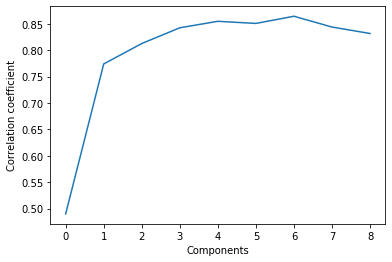

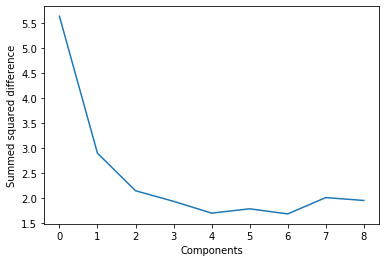

In [81]:
plt.plot(np.max(corrs1, axis=1))
print(np.argmax(corrs1, axis=1))
plt.xlabel('Components')
plt.ylabel('Correlation coefficient')
plt.figure()
plt.plot(np.min(diffs1, axis=1))
plt.xlabel('Components')
plt.ylabel('Summed squared difference')
print(np.max(corrs1))

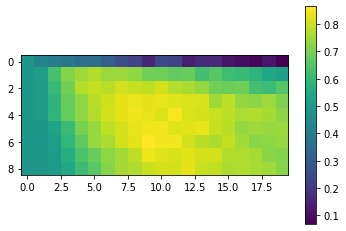

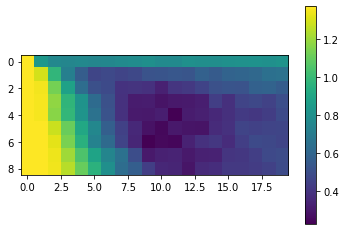

In [76]:
plt.imshow(corrs1)
plt.colorbar()
plt.figure()
plt.imshow(np.log10(diffs1))
plt.colorbar()

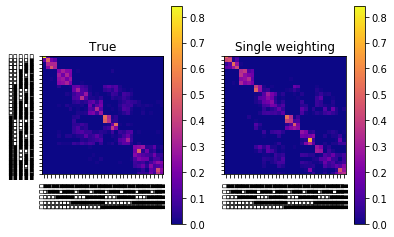

In [77]:
fig, ax = plt.subplots(1, 2)
vmax = np.max([np.max(cm_true1), np.max(cms1[1, 5])])
im = ax[0].imshow(cm_true1, cmap='plasma', vmax=vmax)
im = ax[1].imshow(cms1[1, 5], cmap='plasma', vmax=vmax)
plt.colorbar(im, ax=ax[1])
ax[0].set_title('True')
ax[1].set_title('Single weighting')
ax[0].set_yticks(range(32))
ax[0].set_yticklabels(glyphs);
ax[1].set_yticks(range(32))
ax[1].set_yticklabels([]);
ax[0].set_xticks(range(32))
ax[0].set_xticklabels(glyphs, rotation=90);
ax[1].set_xticks(range(32))
ax[1].set_xticklabels(glyphs, rotation=90);
plt.colorbar(im, ax=ax[0])

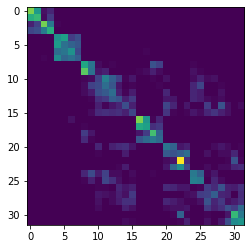

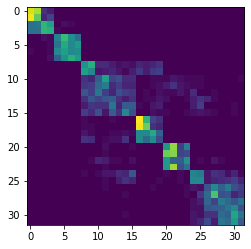

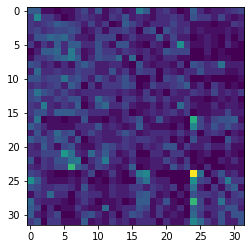

In [80]:
plt.imshow(cms1[1, 5])
plt.figure()
plt.imshow(cms2[2, 9])
plt.figure()
plt.imshow(cms3[0, 5])

In [86]:
model.fit()
thresh = model.opt_out.x[-1]

joined_weights = list(returned_weights1[0]) + [thresh] 

model.fit(W=np.array(joined_weights))

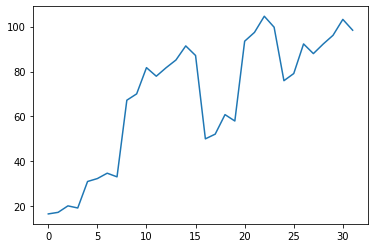

In [32]:
plt.plot(all_returned_models1[1][40].pred_resp)


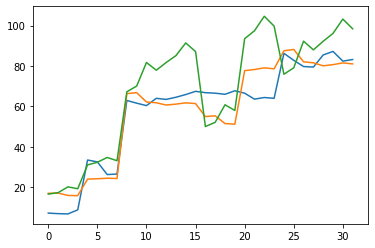

In [33]:
plt.plot(diff_models1[40].true_resp)
plt.plot(diff_models1[40].pred_resp)
plt.plot(all_returned_models1[1][40].pred_resp)


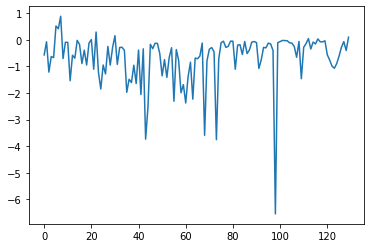

In [35]:
diff_errors1 = np.array([i.fit_score for i in diff_models1])
returned_scores1 = np.array([i.fit_score for i in all_returned_models1[1]])
plt.plot(diff_errors1 - returned_scores1)


In [36]:
print(np.argsort(diff_errors1 - returned_scores1))

[ 98  73  43  68  44  60  55  63  41  58  35  24  59  39  37  11  36 109
  52  61  50  26  23   2  81  21  91 123 122  38  28  18  25  31  16 124
  62  69  57 121  92  51  65  74   8  13  64   4  53 107   3  66 125  12
   0 120  84  49  86  72  97 128  34  17  40  87  56  70 113  42  46  94
  54  71  29  32  77  93 110  33 126 106  27  78  82  83  15  45  96 115
 111  48  47  19  95 105  67 104  75  99  90  10   9 114  88 118 117   1
 127 100  89  85 108  80  76  79 119 103 102 101  14  20 116 112 129  30
  22   6   5   7]


[None, None, None]

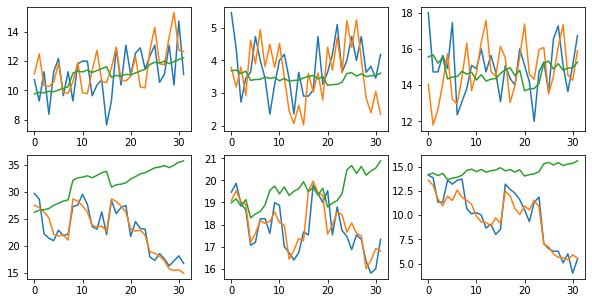

In [49]:
def plot_model_and_single_pred(ax, ui):
    ax.plot(diff_models1[ui].true_resp, label='true')
    ax.plot(diff_models1[ui].pred_resp, label='full model')
    ax.plot(all_returned_models1[1][ui].pred_resp, label='single weighting')

fig = plt.figure(figsize=(10, 5))
gs = GridSpec(2, 3)
axs_best = [fig.add_subplot(gs[0, i]) for i in range(3)]
axs_worst = [fig.add_subplot(gs[1, i]) for i in range(3)]
[plot_model_and_single_pred(i, j) for i, j in zip(axs_best, np.argsort(diff_errors1 - returned_scores1)[-3:])]
[plot_model_and_single_pred(i, j) for i, j in zip(axs_worst, np.argsort(diff_errors1 - returned_scores1)[:3])]


In [126]:
importlib.reload(ebm)
jwms = ebm.JoinedWeightModels(unit_usrt1, good_indexes, model_type=ebm.ExponentialCustomTrialArray, model_args=[ebm.trial_arrays['diff_array']], with_mean=True)
jwms_no_mean = ebm.JoinedWeightModels(unit_usrt1, good_indexes[20:50], model_type=ebm.ExponentialCustomTrialArray, model_args=[ebm.trial_arrays['diff_array']], with_mean=False)

b


In [127]:
jwms.fit_all()

Optimization terminated successfully.
         Current function value: -1312.877227
         Iterations: 19
         Function evaluations: 64041


In [118]:
jwms_no_mean.fit_all()

Optimization terminated successfully.
         Current function value: -1750.101933
         Iterations: 12
         Function evaluations: 9160


In [129]:
[jwms.models[ui].fit(W=jwms.model_weights[ui]) for ui in range(130)];

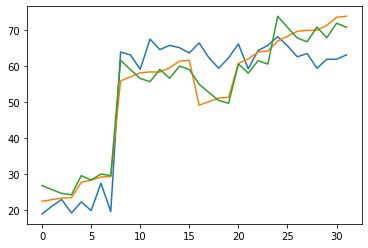

In [125]:
ui = 15
jwms.models[ui].fit(W=jwms.model_weights[ui])
jwms_no_mean.models[ui].fit(W=jwms_no_mean.model_weights[ui])
plt.plot(jwms.models[ui].true_resp)
plt.plot(jwms.models[ui].pred_resp)
plt.plot(jwms_no_mean.models[ui].pred_resp)

In [21]:

def jwms_fit_test(jwms_scattered, method, repeats=5):
    times = []
    for i in range(repeats):
        start = time.time()
        jwms_scattered.fit_all(method=method)
        end = time.time()
        times.append(end-start)
    return times

In [201]:
def joined_fit_method_test(usrt_scattered, index_size, method, repeats=5):
    times = []
    all_jwms = []
    for i in range(5):
        st = time.time()
        indexes = np.random.choice(np.arange(len(good_indexes)), index_size, replace=False)
        jwms = ebm.JoinedWeightModels(usrt_scattered, good_indexes[indexes], model_type=ebm.ExponentialCustomTrialArray, model_args=[ebm.trial_arrays['diff_array']])
        jwms.fit_all(method=method)
        end = time.time()
        times.append(end-st)
        all_jwms.append(jwms)
    return all_jwms, times

In [202]:
all_jwms, times = joined_fit_method_test(unit_usrt1, 15, 'Powell')

Optimization terminated successfully.
         Current function value: -1392.666123
         Iterations: 13
         Function evaluations: 5685
Optimization terminated successfully.
         Current function value: -1619.932694
         Iterations: 12
         Function evaluations: 5200
Optimization terminated successfully.
         Current function value: -1349.868143
         Iterations: 11
         Function evaluations: 4732
Optimization terminated successfully.
         Current function value: -845.905399
         Iterations: 11
         Function evaluations: 4806
Optimization terminated successfully.
         Current function value: -898.777203
         Iterations: 12
         Function evaluations: 5346


In [206]:
usrt_scattered1 = dasked.client.scatter(unit_usrt1)
usrt_scattered2 = dasked.client.scatter(unit_usrt2)
usrt_scattered3 = dasked.client.scatter(unit_usrt3)

In [208]:
it_combos, futures = dasked.gridsearch(joined_fit_method_test, [usrt_scattered1, usrt_scattered2, usrt_scattered3], [15], ['Nelder-Mead', 'Powell', 'BFGS', 'Newton-CG', 'L-BFGS-B', 'TNC', 'COBYLA', 'SLSQP', 'trust-constr'])

In [138]:
def jwms_fit_dask(jwms_scattered, method="Powell"):
    jwms_scattered.fit_all(method=method)
    return jwms_scattered

In [139]:
print(type(jwms_fit_dask))

<class 'function'>


In [158]:
jwms_scattered = dasked.client.scatter(jwms)

In [27]:
futures = dasked.gridsearch(jwms_fit_test, [jwms_scattered], ['Nelder-Mead', 'Powell', 'BFGS', 'L-BFGS-B', 'TNC', 'COBYLA', 'SLSQP', 'trust-constr'])

In [127]:
future = [dask.delayed(jwms_fit_dask)(jwms_scattered, "Powell")]

In [159]:
gs_outs = dasked.gridsearch(jwms_fit_dask, [jwms_scattered])

In [128]:
dask_out = dasked.client.compute(future)

In [305]:
dasked.check_progress()
gridsearch_out_dict = {}
for index, i in enumerate(dasked.current_futures):
    if i.status == 'finished':
        if it_combos[index][-1] not in gridsearch_out_dict.keys():
            gridsearch_out_dict[it_combos[index][-1]] = [i.result()]
        else:
            gridsearch_out_dict[it_combos[index][-1]].append(i.result())

error 3
finished 20
pending 4


In [245]:
def get_scores(gridsearch_out_dict, key):
    all_scores = []
    for i in gridsearch_out_dict[key]:
        jwmss = i[0]
        scores = [j.opt_out.fun for j in jwmss]
        all_scores.append(scores)
    return all_scores
get_scores(gridsearch_out_dict, "Powell")

[[-1320.5627916425265,
  -1828.2245942118834,
  -1262.0809209873128,
  -1365.1294010833205,
  -1497.285291624407],
 [-1382.3082848058777,
  -2027.6903310225912,
  -1683.9665822382387,
  -1618.7501173603623,
  -2332.016783767688],
 [-1828.9576294783014,
  -1208.6478731681511,
  -1942.1422348972862,
  -2056.9722120307733,
  -1513.4279969927227]]

Text(0.5, 0, 'Time (s)')

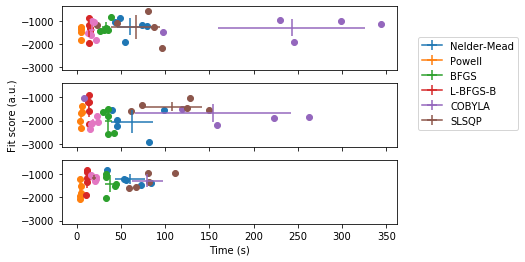

In [304]:

def plot_scores_and_times(gridsearch_out_dict, odour_index, ax=None):
    if ax is None:
        ax = plt.subplot(111)
    for index, i in enumerate(gridsearch_out_dict.keys()):
        try:
            ax.scatter(gridsearch_out_dict[i][odour_index][1], get_scores(gridsearch_out_dict, i)[odour_index], c=f'C{index}')

            ax.errorbar(np.mean(gridsearch_out_dict[i][odour_index][1], axis=0), np.mean(get_scores(gridsearch_out_dict, i)[odour_index], axis=0), xerr=np.std(gridsearch_out_dict[i][odour_index][1], axis=0), yerr=np.std(get_scores(gridsearch_out_dict, i)[odour_index], axis=0), label=i)
        except:
            pass
    # ax.legend()
    # ax.xlabel("Time (s)")
    # ax.ylabel('Fit error (a.u.)')
#plot_scores_and_times(gridsearch_out_dict, 0)
fig, ax = plt.subplots(3, 1, sharex=True, sharey=True)
[plot_scores_and_times(gridsearch_out_dict, k, ax=ax[k]) for k in range(3)]
ax[-1].legend(loc='upper left', bbox_to_anchor=(1.05, 3))
ax[1].set_ylabel('Fit score (a.u.)')
ax[-1].set_xlabel("Time (s)")


In [167]:
jwms_done_fit = dasked.collect_results()

In [307]:
pickle.dump(jwms_done_fit[0], open("230405_joint_weighting_models1.pkl", "wb"))

In [6]:
jwms = pickle.load(open("230405_joint_weighting_models1.pkl", "rb"))

In [ ]:
[i.fit() for i in conc_models1];
[i.fit() for i in onset_models1];
[i.fit() for i in diff_models1];

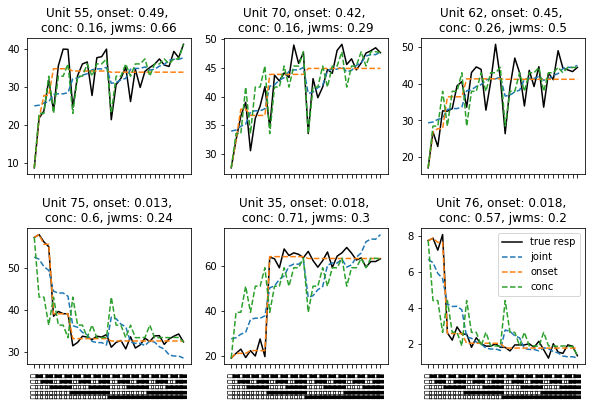

In [72]:
ui = 55
def plot_cell_responses(ui, ax=None):
    if ax is None:
        ax = plt.subplot(111)
    ax.plot(jwms.models[ui].true_resp, label="true resp", color='k')
    ax.plot(jwms.models[ui].pred_resp, label="joint", linestyle='--')
    ax.plot(onset_models1[ui].pred_resp, label="onset", linestyle='--')
    ax.plot(conc_models1[ui].pred_resp, label="conc", linestyle='--')

    ax.set_title(f"Unit {ui}, onset: {onset_models1[ui].fit_score:0.2}, \nconc: {conc_models1[ui].fit_score:0.2}, jwms: {jwms.models[ui].fit_score:0.2}")
    ax.set_xticks(range(32))
    ax.set_xticklabels(labels=glyphs, rotation=90)

# plt.plot(jwms.models[ui].true_resp, label="true resp", color='k')
# plt.plot(jwms.models[ui].pred_resp, label="joint", linestyle='--')
# plt.plot(onset_models1[ui].pred_resp, label="onset", linestyle='--')
# plt.plot(conc_models1[ui].pred_resp, label="conc", linestyle='--')
# #plt.plot(diff_models1[ui].pred_resp, label="diff", linestyle='--')
# plt.title(f"Unit {ui}, onset_score: {onset_models1[ui].fit_score:0.2}, conc_score: {conc_models1[ui].fit_score:0.2}, jwms_score: {jwms.models[ui].fit_score:0.2}, diff_score: {diff_models1[ui].fit_score:0.2}")
# plt.xticks(range(32), labels=glyphs, rotation=90)
# plt.legend()
fig = plt.figure(figsize=(10, 6))
gs = GridSpec(2, 3, hspace=0.4)
conc_axs = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1]), fig.add_subplot(gs[0, 2])]
onset_axs = [fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[1, 1]), fig.add_subplot(gs[1, 2])]
[plot_cell_responses(i, ax=conc_axs[k]) for k, i in enumerate([55, 70, 62])]
[plot_cell_responses(i, ax=onset_axs[k]) for k, i in enumerate([75, 35, 76])]
[i.set_xticklabels([]) for i in conc_axs]
onset_axs[-1].legend()

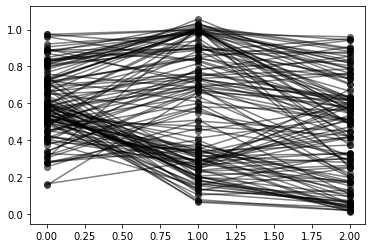

In [54]:
#plt.violinplot([[i.fit_score for i in jwms.models], [i.fit_score for i in conc_models1], [i.fit_score for i in diff_models1]], showmeans=True)

plt.scatter([0 for i in range(130)], [i.fit_score for i in conc_models1], c='k', alpha=0.5)
plt.scatter([2 for i in range(130)], [i.fit_score for i in onset_models1], c='k', alpha=0.5)
plt.scatter([1 for i in range(130)], [i.fit_score for i in jwms.models], c='k', alpha=0.5)
for i in range(130):
    plt.plot([0, 1, 2], [conc_models1[i].fit_score, jwms.models[i].fit_score, onset_models1[i].fit_score], c='k', alpha=0.5)

In [60]:
print(np.argsort([i.fit_score for i in conc_models1]))

[ 55  70  62 126 125 115 121  66 109 107 105 118  59 124 119  31  58 123
  54  29 113 122  64 127 114  26 117 112  83  60  90  68 101  50 100  41
 116  74 120  11  52  99  63  92  47 103  33  81  91  84  85  51  43  21
 129  30  18  48  44  76  40 108  88 102  56  23 106  10  71 104 128  34
  49  75  95  79   2  80  27  87  45  14  42  98  65  73  96  57  93   8
  77  61  35 110  94  53  37   5  32  36  39   4  72   3   7  16  86  46
   0  67  28  22  69  89   6  20  82   1 111  15  97  13  24  12   9  17
  78  38  25  19]


In [38]:
print(np.argsort([i.fit_score for i in conc_models1]))
print(np.argsort([i.fit_score for i in onset_models1]))


[ 55  70  62 126 125 115 121  66 109 107 105 118  59 124 119  31  58 123
  54  29 113 122  64 127 114  26 117 112  83  60  90  68 101  50 100  41
 116  74 120  11  52  99  63  92  47 103  33  81  91  84  85  51  43  21
 129  30  18  48  44  76  40 108  88 102  56  23 106  10  71 104 128  34
  49  75  95  79   2  80  27  87  45  14  42  98  65  73  96  57  93   8
  77  61  35 110  94  53  37   5  32  36  39   4  72   3   7  16  86  46
   0  67  28  22  69  89   6  20  82   1 111  15  97  13  24  12   9  17
  78  38  25  19]
[ 75  35  76  88  95  99  85  80  93  72  94  96  79 126 103  34  90  40
 119 101 117  48 115 105 100  74 104  10  45 121  87  29 114   3 107  47
  86  18  82  84  33 116 109  27  21 118 125 102  31  23  83  49  42  51
  92 112  54  70  11  56  62 113  41   0  39  66  55  26  30 108  32  91
  44  81  37 106  78 124  36  38 129  43 127  50  13   9 123  14 120   5
  64  59 111   8   2 128  98  46  12  20 122  77  28   4 110   6  89  52
  73  69  68  15  97  19   7   1 

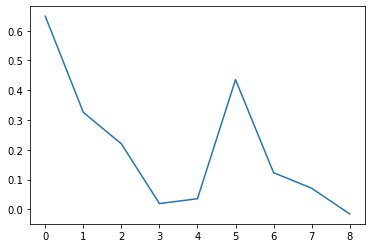

In [170]:
plt.plot(jwms_done_fit[0].opt_out.x[:9])

In [133]:
all_futures = []
for i in range(20):
    generate_and_dask(jwms.models, method='add', noise_level=i)
    all_futures.append(dasked.current_futures)

all_futures = np.concatenate(all_futures)
all_futures = list(all_futures)
dasked.current_futures = all_futures

In [139]:
dasked.check_progress()

finished 2000


In [140]:
res = dasked.collect_results()
res = np.array(res).reshape(20, 100, 2, 32)
preds1 = res[:, :, 0]
trues1 = res[:, :, 1]
cms1 = [confusion_matrix(trues1[i].flatten(), preds1[i].flatten(), labels=range(32), normalize='true') for i in range(20)]

6
7
0.7442845137534363
2.9572000000000003


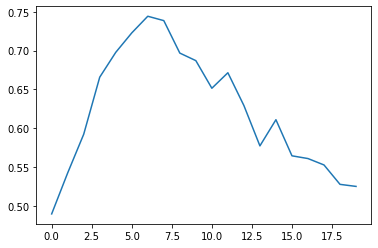

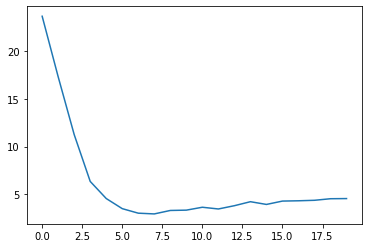

In [141]:
plt.plot([np.corrcoef(cms1[i].flatten(), cm_true1.flatten())[0, 1] for i in range(20)])
print(np.argmax([np.corrcoef(cms1[i].flatten(), cm_true1.flatten())[0, 1] for i in range(20)]))
plt.figure()
plt.plot([np.sum((i - cm_true1)**2) for i in cms1])
print(np.argmin([np.sum((i - cm_true1)**2) for i in cms1]))
print(np.max([np.corrcoef(cms1[i].flatten(), cm_true1.flatten())[0, 1] for i in range(20)]))
print(np.min([np.sum((i - cm_true1)**2) for i in cms1]))

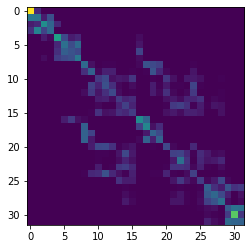

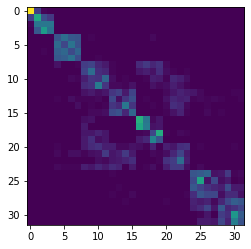

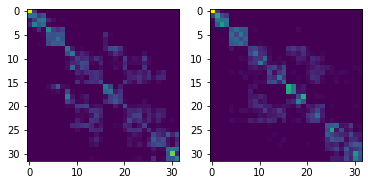

In [142]:
plt.imshow(cms1[5])
plt.figure()
plt.imshow(cm_true1)
fig, ax = plt.subplots(1, 2)
ax[0].imshow(cms1[6])
ax[1].imshow(cm_true1)

In [ ]:
fig, ax = plt.

In [178]:
scaled_weights = []
for i in range(130):
    scaled_weights.append(list(jwms_done_fit[0].opt_out.x[:9] * jwms_done_fit[0].opt_out.x[9+i]) + [jwms_done_fit[0].opt_out.x[139+i]])

In [184]:
[jwms_done_fit[0].models[i].fit(W=scaled_weights[i]) for i in range(130)];

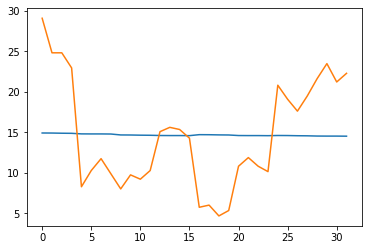

In [194]:
ui = 36
plt.plot(jwms_done_fit[0].models[ui].pred_resp)
plt.plot(jwms_done_fit[0].models[ui].true_resp)

In [172]:
jwms_done_fit[0].models[0].fit(W=jwms_done_fit[0].opt_out.x[:9]*)

AttributeError: 'ExponentialCustomTrialArray' object has no attribute 'pred_resp'

In [133]:
print(dask_out[0].result()[0].opt_out.x)

[ 0.7419044   0.14427105 -0.05426652  0.06069973 -0.09576279  0.73921347
  0.19728023 -0.0712585   0.06488433  0.09146446 -0.7859229  -0.22619022
  0.43205613  1.20182163  1.11734349 -0.31088668 -0.25729879 -0.12233564
 -0.08969072  3.00447902  2.90495413  3.75157333  2.78375398  1.92167055
  3.20175335  2.87481697  3.20901155  1.82429117  3.29827864]


In [65]:
jwms_fit = dasked.client.gather(dask_out)

In [67]:
print(jwms_fit.opt_out.x.shape)

(29,)


In [48]:
for i in futures[1]:
    print(i.status)
    if i.status == 'finished':
        print(i.result(), np.mean(i.result()))
    print('\n')

finished
[21.58863353729248, 21.02718234062195, 21.11420750617981, 21.263686656951904, 21.4548442363739] 21.28971085548401


finished
[3.81746506690979, 2.538914680480957, 2.4064700603485107, 2.2887439727783203, 2.2901103496551514] 2.668340826034546


pending


finished
[15.736938953399658, 15.234894037246704, 15.035630941390991, 14.746702909469604, 14.822975635528564] 15.115428495407105


finished
[5.600743293762207, 5.565298795700073, 5.600766897201538, 5.821998357772827, 5.942562103271484] 5.706273889541626


finished
[130.00614380836487, 130.42541193962097, 130.8889684677124, 130.08179688453674, 129.70482230186462] 130.22142868041993


finished
[56.947492361068726, 55.779189109802246, 55.78456902503967, 51.31868362426758, 47.63679885864258] 53.49334659576416


finished
[10.510030031204224, 10.49241828918457, 10.51356840133667, 10.766836166381836, 10.685900688171387] 10.593750715255737


finished
[1422.6899712085724, 1210.30992269516, 1274.044560432434, 1366.7610847949982, 1331.7649

In [10]:
def dask_print_test():
    print('a')


In [11]:
future = dask.delayed(dask_print_test)()
dask_out = dasked.client.compute(future)
dasked.current_futures = [dask_out]
dasked.check_progress()

pending 1


In [18]:
dasked.current_futures[0].result() 

In [55]:
jwms.fit_all(method="Powell")

Optimization terminated successfully.
         Current function value: -1496.582031
         Iterations: 14
         Function evaluations: 16994


In [51]:
%timeit jwms.fit_all(method=None)
%timeit jwms.fit_all(method="Powell")


         Current function value: -2928.228597
         Iterations: 509
         Function evaluations: 17370
         Gradient evaluations: 579
         Current function value: -2928.228597
         Iterations: 509
         Function evaluations: 17370
         Gradient evaluations: 579
         Current function value: -2928.228597
         Iterations: 509
         Function evaluations: 17370
         Gradient evaluations: 579
         Current function value: -2928.228597
         Iterations: 509
         Function evaluations: 17370
         Gradient evaluations: 579
         Current function value: -2928.228597
         Iterations: 509
         Function evaluations: 17370
         Gradient evaluations: 579
         Current function value: -2928.228597
         Iterations: 509
         Function evaluations: 17370
         Gradient evaluations: 579
1 loop, best of 5: 6.8 s per loop
Optimization terminated successfully.
         Current function value: -2926.693339
         Iterations: 13


[0.25655913233407945, 0.1401681751726752, 0.055097277577683, 0.058432066169525315, -0.0015411422328260112, 0.17712400511290752, 0.106723731130379, 0.07974404170808463, 0.10313492302298517, 2.659699426950321]


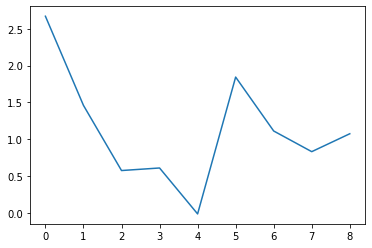

In [27]:
plt.plot(jwms.opt_out.x[:9])
base_weights = jwms.opt_out.x[:9]
amps = []
threshes = []
amps = jwms.opt_out.x[9:39]
threshes = jwms.opt_out.x[39:]
ws = []

for i in range(30):
    ws.append(list(base_weights * amps[i]) + [threshes[i]])
print(ws[0])
[i.fit(W=w) for i, w in zip(jwms.models, ws)];


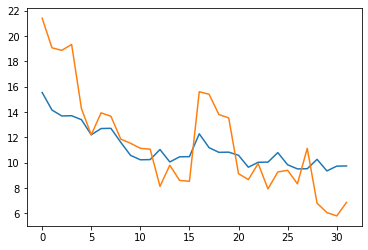

In [61]:
jwms.opt_out.x[:9]

plt.plot(jwms.models[1].pred_resp)
plt.plot(jwms.models[1].true_resp)


In [54]:
test = [ebm.trial_arrays['diff_array']]
test = []
model_test = ebm.ExponentialJoinedWeights(unit_usrt1, 9, *test)
model_test.fit()

In [61]:
def test_joint():

    def __init__(self, unit_usrt, unit_ids, stim_count_type='mean', model_type=ebm.ExponentialJoinedWeights, model_kwargs={}):
        self.models = [model_type(unit_usrt, i, stim_count_type, **model_kwargs) for i in unit_ids]
test_joint(unit_usrt1, good_indexes, ebm.Exponential)

KeyboardInterrupt: 

In [64]:
print(unit_usrt1.shape)

(145, 32)
